In [1]:
import os
from scipy.constants import physical_constants
import sympy as smp
import matplotlib.pyplot as plt
import scipy.special as sp
import numpy as np

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "text.latex.preamble": r"\usepackage{amsfonts}"
})

current_directory = os.getcwd()
print(current_directory)

c:\Users\thomm\Documents\GitHub\fisica-matematica-2\tareas\tarea-3


#### $$R_{n \ell}(r) = \sqrt{\left( \frac{2}{n a_0} \right)^3 \frac{(n-\ell-1)!}{2n(n+\ell)!}} e^{-\frac{r}{n a_0}} \left( \frac{2r}{n a_0} \right)^{\ell} L_{n-\ell-1}^{2\ell+1}\left(\frac{2r}{n a_0}\right)$$

In [2]:
def radial_function(n, l, r, a0):
    laguerre = sp.genlaguerre(n - l - 1, 2 * l + 1)
    p = 2 * r / (n * a0)

    constant_factor = np.sqrt(
        ((2 / n * a0) ** 3 * (sp.factorial(n - l - 1))) /
        (2 * n * (sp.factorial(n + l)))
    )
    return constant_factor * np.exp(-p / 2) * (p ** l) * laguerre(p)

#### $$Y_{\ell}^{m}(\theta, \varphi) = (-1)^m \sqrt{\frac{(2\ell+1)}{4\pi}\frac{(\ell-m)!}{(\ell+m)!}} P_{\ell}^{m}(\cos\theta) e^{im\varphi}$$

In [3]:
def angular_function(m, l, theta, phi):

    legendre = sp.lpmv(m, l, np.cos(theta))

    constant_factor = ((-1) ** m) * np.sqrt(
        ((2 * l + 1) * sp.factorial(l - np.abs(m))) /
        (4 * np.pi * sp.factorial(l + np.abs(m)))
    )
    return constant_factor * legendre * np.real(np.exp(1.j * m * phi))

#### $$\Theta_{lm}(\theta,\varphi) = |Y_l^m (\theta,\varphi)|^2$$

In [4]:
def square_of_angular_function(m, l, theta, phi):
    return np.abs(angular_function(m, l, theta, phi)) ** 2

#### Plotting $\Theta_{lm}(\theta,\varphi)$

In [5]:
def plot_theta_lm(l,m):

    theta = np.linspace(0, np.pi, 200)
    phi = np.linspace(0, 2 * np.pi, 200)
    theta, phi = np.meshgrid(theta, phi)

    Th = square_of_angular_function(m, l, theta, phi)

    # Convert to Cartesian coordinates for 3D plotting
    x = Th * np.sin(theta) * np.cos(phi)
    y = Th * np.sin(theta) * np.sin(phi)
    z = Th * np.cos(theta)

    # Plot the 3D surface
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, z, cmap='viridis')

    ax.set_xlabel('$x$ [pm]')
    ax.set_ylabel('$y$ [pm]')
    ax.set_title(f'$|Y_{l}^{m} (\\theta, \\varphi)|^2$', color = 'black')

    plt.savefig(f'figures/theta{l}{m}.pdf', format='pdf')
    plt.show()

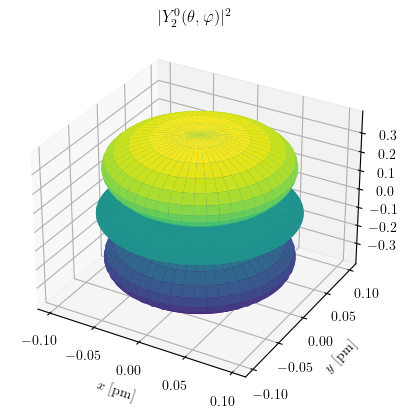

In [6]:
plot_theta_lm(2,0)

Computing:

#### $$\psi_{n l m}(r, \theta, \varphi) = R_{n \ell}(r) Y_{\ell}^{m}(\theta, \varphi)$$

and

#### $$|\psi_{n l m}(r, \theta, \varphi)|^2$$


In [7]:
def compute_probability_density(n, l, m, a0_scale_factor):
    # Scale Bohr radius for effective visualization
    a0 = a0_scale_factor * physical_constants['Bohr radius'][0] * 1e+12

    # x-y grid to represent electron spatial distribution
    grid_extent = 480
    grid_resolution = 680
    x = y = np.linspace(-grid_extent, grid_extent, grid_resolution)
    x, y = np.meshgrid(x, y)

    # Use epsilon to avoid division by zero during angle calculations
    eps = np.finfo(float).eps

    # Ψnlm(r,θ,φ) = Rnl(r).Ylm(θ,φ)
    psi = radial_function(
        n, l, np.sqrt((x ** 2 + y ** 2)), a0
    ) * angular_function(
        m, l, np.arctan(x / (y + eps)), 0
    )
    psi_abs_square = np.abs(psi)**2

    # Find the index of the maximum value
    max_index = np.argmax(psi_abs_square)

    # Convert the index to 2D index
    max_index_2d = np.unravel_index(max_index, psi_abs_square.shape)

    # Get the corresponding (x, y) point
    max_point = (x[max_index_2d], y[max_index_2d])

    return psi_abs_square, x, y, max_point


#### Plotting $|\psi_{n l m}(r, \theta, \varphi)|^2$


In [24]:
def plot_wf_probability_density(n, l, m, a0_scale_factor):

    colormap='viridis'

    # Quantum numbers validation
    if not isinstance(n, int) or n < 1:
        raise ValueError('n should be an integer satisfying the condition: n >= 1')
    if not isinstance(l, int) or not (0 <= l < n):
        raise ValueError('l should be an integer satisfying the condition: 0 <= l < n')
    if not isinstance(m, int) or not (-l <= m <= l):
        raise ValueError('m should be an integer satisfying the condition: -l <= m <= l')

    # Compute and visualize the wavefunction probability density
    prob_density, x, y, max_point = compute_probability_density(n, l, m, a0_scale_factor)

    fig, ax = plt.subplots()
    cax = ax.imshow(prob_density, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap=colormap)
    cbar = fig.colorbar(cax, ax=ax, label='Probability Density')
    cbar.set_ticks([prob_density.min(), prob_density.max()])
    cbar.set_ticklabels(['$-$', '$+$'])

    ax.set_title(r'Probability density $|\psi_{nlm}|^2$' + f' with $n = {n}$, $l = {l}$ and $m={m}$.', color='black')

    plt.savefig(f'figures/density{n}{l}{m}.pdf', format='pdf')
    plt.show()

    probable_radius = np.sqrt(max_point[0]**2 + max_point[1]**2)
    print(f'The probability density maximices at r = {probable_radius:.2f} in units of the Bohr radius.')

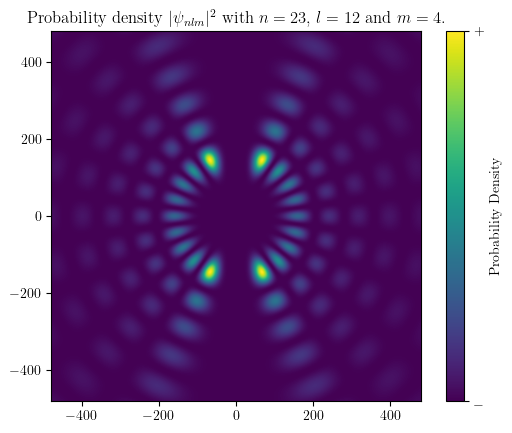

The probability density maximices at r = 159.72 in units of the Bohr radius.


In [29]:
''' Arguments:
    n : A natural number
    l : 0, 1, ..., n
    m : -l, ..., 0, ..., l
    scale factor: (for visualization only)
'''

plot_wf_probability_density(23, 12, 4, 0.03)